# I. Importing Libraries

## Problem statement :

Bank XYZ has been observing a lot of customers closing their accounts or switching to competitor banks over the past couple of quarters. As such, this has caused a huge dent in the quarterly revenues and might drastically affect annual revenues for the ongoing financial year, causing stocks to plunge and market cap to reduce by X %. A team of business, product, engineering and data science folks have been put together to arrest this slide. 

__Objective__ : Can we build a model to predict, with a reasonable accuracy, the customers who are going to churn in the near future? Being able to accurately estimate when they are going to churn will be an added bonus

__Definition of churn__ : A customer having closed all their active accounts with the bank is said to have churned. Churn can be defined in other ways as well, based on the context of the problem. A customer not transacting for 6 months or 1 year can also be defined as to have churned, based on the business requirements.

__Product Manager's perspective :__  

(1) Business goal : Arrest decrease in revenues or loss of active customers of bank

(2) Identify data source : There are different source of data. Some of these could be Transactional systems, event-based logs, Data warehouse (MySQL DBs, Redshift/AWS), Data Lakes, NoSQL DBs.

(3) Audit for data quality : De-duplication of events/transactions, Complete or partial absence of data for chunks of time in between, Obscuring PII (personal identifiable information) data 

(4) Business and Data-related metrics : Tracking these metrics over time, probably through some intuitive visualizations
    
    (i) Business metrics : Churn rate (month-on-month, weekly/quarterly), Trend of avg. number of products per customer, 
        %age of dormant customers, Other such descriptive metrics
    
    (ii) Data-related metrics : F1-score, Recall, Precision
         Recall = TP/(TP + FN) 
         Precision = TP/(TP + FP)
         F1-score = Harmonic mean of Recall and Precision
         where, TP = True Positive, FP = False Positive and FN = False Negative

(5) Prediction model output format : These models doesn't require deployment. Instead, we can run these models periodically (monthly/quarterly) and the list of customers along with their propensity to churn can be shared with the business (Sales/Marketing) or Product team.

* Business metrics : If we take Recall target as __70%__ which means correctly identifying 70% of customers who's going to churn in the near future, we can expect that due to business intervention (offers, getting in touch with customers etc.), 50% of the customers can be saved from being churned, which means atleast a __35%__ improvement in Churn Rate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# II. Importing Data and Descriptive Statistical Analysis

In [4]:
df = pd.read_csv('../data/BankingCustomerData.csv')

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df.shape

(10000, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# III. Basic EDA

In [8]:
df.describe() # Describe all numerical columns
df.describe(include = ['O']) # Describe all non-numerical/categorical columns

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [9]:
## Checking number of unique customers in the dataset
df.shape[0], df.CustomerId.nunique()

(10000, 10000)

In [10]:
df_surname = df.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

df_surname.head()

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


In [11]:
df['Geography'].value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

 - Discard row number
 - Discard CustomerID as well, since it doesn't convey any extra info. Each row pertains to a unique customer
 - Based on the above, columns/features can be segregated into non-essential, numerical, categorical and target variables

In [12]:
## Separating out different columns into various categories as defined above
target_variable = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']

# Tenure and NumOfProducts are ordinal variables. 
continuous_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# HasCrCard and IsActiveMember are actually binary categorical variables.
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [13]:
## Separating out target variable and removing the non-essential columns
y = df[target_variable].values
df.drop(cols_to_remove, axis=1, inplace=True)

### Questioning the data :

 - No date/time column. A lot of useful features can be built using date/time columns
 - When was the data snapshot taken? There are certain customer features like : Balance, Tenure, NumOfProducts, EstimatedSalary, which will have different values across time
 - Are all these values/features pertaining to the same single date or spread across multiple dates?
 - How frequently these customer features are updated?
 - Is it be possible to have the values of these features over a period of time as opposed to a single, snapshot date?
 - Some customers who have exited shows balance in their account, or a non-zero NumOfProducts. Does this mean they have churned only from a specific product and not the entire bank, or are these snapshots are not updated?
 - Some features like, number and kind of transactions, can help us estimate the degree of activity of the customer, instead of trusting the binary variable IsActiveMember
 - Customer transaction patterns can also help us ascertain whether the customer has actually churned or not. For example, a customer might transact daily/weekly vs a customer who transacts annuallly
 
 Here, the objective is to understand the data and the problem statement to achieve the stated goal. In the process, if more data/context can be obtained, it may help us improve model performance

### Missing values and outlier treatment

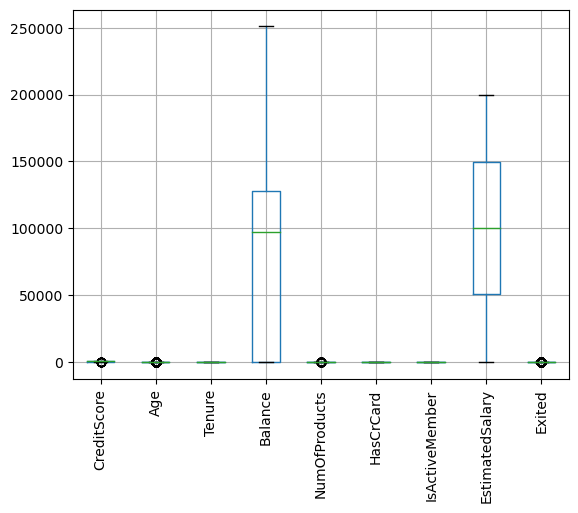

In [14]:
df.boxplot()
plt.xticks(rotation=90)
plt.show();

#### Outliers

* Can be observed from univariate plots of different features

* Outliers can either be logically improbable (as per the feature definition) or just an extreme value as compared to the feature distribution

* As part of outlier treatment, the particular row containing the outlier can be removed from the training set, provided they do not form a significant chunk of the dataset (< 0.5-1%)

* In cases where the value of outlier is logically faulty, e.g. negative Age or CreditScore > 900, the particular record can be replaced with mean of the feature or the nearest among min/max logical value of the feature

Outliers in numerical features can be of a very high/low value, lying in the top 1% or bottom 1% of the distribution or values which are not possible as per the feature definition.

Outliers in categorical features are usually levels with a very low frequency/no. of samples as compared to other categorical levels.

__No outliers observed in any feature of this dataset__

#### Missing values

In [15]:
## No missing values!
df.isnull().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No missing values present in this dataset. Can also be observed from df.describe() commands. However, most real-world datasets might have missing values. A couple of things which can be done in such cases :
 - If the column/feature has too many missing values, it can be dropped as it might not add much relevance to the data
 - If there a few missing values, the column/feature can be imputed with its summary statistics (mean/median/mode) and/or numbers like 0, -1 etc. which add value depending on the data and context. For example, say, BalanceInAccount.

### Categorical variable encoding

As a rule of thumb, we can consider using :

 1. Label Encoding ---> Binary categorical variables and Ordinal variables
 2. One-Hot Encoding ---> Non-ordinal categorical variables with low to mid cardinality (< 5-10 levels)
 3. Target encoding ---> Categorical variables with > 10 levels

* HasCrCard and IsActiveMember are already label encoded
* For Gender, a simple Label encoding should be fine.
* For Geography, since there are 3 levels, OneHotEncoding should do the trick
* For Surname, we'll try Target/Frequency Encoding

#### Label Encoding for binary variables

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder_gender = LabelEncoder()
df['Gender'] = label_encoder_gender.fit_transform(df['Gender'])

In [17]:
label_encoder_gender.classes_

array(['Female', 'Male'], dtype=object)

In [18]:
label_encoder_gender_mapping = dict(zip(label_encoder_gender.classes_, label_encoder_gender.transform(label_encoder_gender.classes_)))
label_encoder_gender_mapping

{'Female': 0, 'Male': 1}

In [19]:
df.head(10)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
5,Chu,645,Spain,1,44,8,113755.78,2,1,0,149756.71,1
6,Bartlett,822,France,1,50,7,0.00,2,1,1,10062.80,0
7,Obinna,376,Germany,0,29,4,115046.74,4,1,0,119346.88,1
8,He,501,France,1,44,4,142051.07,2,0,1,74940.50,0
9,H?,684,France,1,27,2,134603.88,1,1,1,71725.73,0


#### OneHot Encoding for binary variables

In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder_geography = LabelEncoder()
geography_series = label_encoder_geography.fit_transform(df['Geography'])

In [21]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
ohe_geography= ohe.fit_transform(geography_series.reshape(df.shape[0],1))
ohe_geography

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [22]:
ohe_geography.astype(int)

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [23]:
label_encoder_geography_mapping = dict(zip(label_encoder_geography.classes_, label_encoder_geography.transform(label_encoder_geography.classes_)))
label_encoder_geography_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

#### Adding the one-hot encoded columns to the dataframe and removing the original feature

In [24]:
encoded_colum_name = ['Country_' + i for i in label_encoder_geography_mapping.keys()]
encoded_colum_name

['Country_France', 'Country_Germany', 'Country_Spain']

In [25]:
df = pd.concat([df, pd.DataFrame(ohe_geography.astype(int), columns= encoded_colum_name)], axis=1)
df.drop('Geography',axis=1, inplace=True)
df.head(10)
df.tail(10)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain
0,Hargrave,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,Hill,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,Onio,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,Boni,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,Mitchell,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1
5,Chu,645,1,44,8,113755.78,2,1,0,149756.71,1,0,0,1
6,Bartlett,822,1,50,7,0.00,2,1,1,10062.80,0,1,0,0
7,Obinna,376,0,29,4,115046.74,4,1,0,119346.88,1,0,1,0
8,He,501,1,44,4,142051.07,2,0,1,74940.50,0,1,0,0
9,H?,684,1,27,2,134603.88,1,1,1,71725.73,0,1,0,0


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain
9990,Nkemakonam,714,1,33,3,35016.60,1,1,0,53667.08,0,0,1,0
9991,Ajuluchukwu,597,0,53,4,88381.21,1,1,0,69384.71,1,1,0,0
9992,Chukwualuka,726,1,36,2,0.00,1,1,0,195192.40,0,0,0,1
9993,Rahman,644,1,28,7,155060.41,1,1,0,29179.52,0,1,0,0
9994,Wood,800,0,29,2,0.00,2,0,0,167773.55,0,1,0,0
9995,Obijiaku,771,1,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,Johnstone,516,1,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,Liu,709,0,36,7,0.00,1,0,1,42085.58,1,1,0,0
9998,Sabbatini,772,1,42,3,75075.31,2,1,0,92888.52,1,0,1,0
9999,Walker,792,0,28,4,130142.79,1,1,0,38190.78,0,1,0,0


#### Target Encoding for variables

This kind of target encoding is sometimes called a mean encoding. Applied to a binary target, it's also called bin counting. (Other names you might come across include: __likelihood encoding__, __impact encoding__, and __leave-one-out encoding__.

In [26]:
surname_means = df.groupby(['Surname']).Exited.mean()
surname_means.head()

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

In [27]:
global_mean = surname_means.mean()

In [28]:
## Creating new encoded features for surname - Target (mean) encoding
df['Surname_mean_churn'] = df.Surname.map(surname_means)
df['Surname_mean_churn'].fillna(global_mean, inplace=True)
df.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain,Surname_mean_churn
0,Hargrave,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0,1.000000
1,Hill,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1,0.117647
2,Onio,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0,0.250000
3,Boni,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0,0.214286
4,Mitchell,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1,0.100000


But, the problem with Target encoding is that it might cause data leakage, as we are considering feedback from the target variable while computing any summary statistic.

A solution is to use a modified version : Leave-one-out Target encoding.

In this, for a particular data point or row, the mean of the target is calculated by considering all rows in the same categorical level except itself. This mitigates data leakage and overfitting to some extent.

Mean for a category, __m<sub>c</sub> = S<sub>c</sub> / n<sub>c</sub>__    .....   (1)

What we need to find is the mean excluding a single sample. This can be expressed as : __m<sub>i</sub> = (S<sub>c</sub> - t<sub>i</sub>) / (n<sub>c</sub> - 1)__     .....   (2)

Using (1) and (2), we can get : __m<sub>i</sub> = (n<sub>c</sub>m<sub>c</sub> - t<sub>i</sub>) / (n<sub>c</sub> - 1)__

Here, _S<sub>c</sub>_ = Sum of target variable for category c

_n<sub>c</sub>_ = Number of rows in category c   

_t<sub>i</sub>_ = Target value of the row whose encoding is being calculated


In [29]:
## Calculate frequency of each category
surname_freqs = df.groupby(['Surname']).size()
surname_freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     2
dtype: int64

In [30]:
## Create frequency encoding - Number of instances of each category in the data
df['Surname_freqs'] = df.Surname.map(surname_freqs)
df['Surname_freqs'].fillna(0, inplace=True)

In [31]:
## Create Leave-one-out target encoding for Surname
df['Surname_enc'] = ((df.Surname_freqs * df.Surname_mean_churn) - df.Exited)/(df.Surname_freqs - 1)
df.head(10)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain,Surname_mean_churn,Surname_freqs,Surname_enc
0,Hargrave,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0,1.000000,1,NaN
1,Hill,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1,0.117647,17,0.125000
2,Onio,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0,0.250000,8,0.142857
3,Boni,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0,0.214286,14,0.230769
4,Mitchell,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1,0.100000,20,0.105263
5,Chu,645,1,44,8,113755.78,2,1,0,149756.71,1,0,0,1,0.136364,22,0.095238
6,Bartlett,822,1,50,7,0.00,2,1,1,10062.80,0,1,0,0,0.250000,4,0.333333
7,Obinna,376,0,29,4,115046.74,4,1,0,119346.88,1,0,1,0,0.500000,2,0.000000
8,He,501,1,44,4,142051.07,2,0,1,74940.50,0,1,0,0,0.277778,18,0.294118
9,H?,684,1,27,2,134603.88,1,1,1,71725.73,0,1,0,0,0.052632,19,0.055556


In [32]:
## Fill NaNs occuring due to category frequency being 1 or less
df['Surname_enc'].fillna((((df.shape[0] * global_mean) - df.Exited) / (df.shape[0] - 1)), inplace=True)
df.head(10)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain,Surname_mean_churn,Surname_freqs,Surname_enc
0,Hargrave,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0,1.000000,1,0.199072
1,Hill,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1,0.117647,17,0.125000
2,Onio,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0,0.250000,8,0.142857
3,Boni,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0,0.214286,14,0.230769
4,Mitchell,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1,0.100000,20,0.105263
5,Chu,645,1,44,8,113755.78,2,1,0,149756.71,1,0,0,1,0.136364,22,0.095238
6,Bartlett,822,1,50,7,0.00,2,1,1,10062.80,0,1,0,0,0.250000,4,0.333333
7,Obinna,376,0,29,4,115046.74,4,1,0,119346.88,1,0,1,0,0.500000,2,0.000000
8,He,501,1,44,4,142051.07,2,0,1,74940.50,0,1,0,0,0.277778,18,0.294118
9,H?,684,1,27,2,134603.88,1,1,1,71725.73,0,1,0,0,0.052632,19,0.055556


In [33]:
### Deleting the 'Surname' and other redundant column across the three datasets
df.drop(['Surname_mean_churn'], axis=1, inplace=True)
df.drop(['Surname_freqs'], axis=1, inplace=True)
df.drop(['Surname'], axis=1, inplace=True)
df.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain,Surname_enc
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0,0.199072
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1,0.125000
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0,0.142857
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0,0.230769
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1,0.105263
5,645,1,44,8,113755.78,2,1,0,149756.71,1,0,0,1,0.095238
6,822,1,50,7,0.00,2,1,1,10062.80,0,1,0,0,0.333333
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0,1,0,0.000000
8,501,1,44,4,142051.07,2,0,1,74940.50,0,1,0,0,0.294118
9,684,1,27,2,134603.88,1,1,1,71725.73,0,1,0,0,0.055556


### Some basic feature engineering

Creating some new features based on simple interactions between the existing features.

* Balance/NumOfProducts
* Balance/EstimatedSalary
* Tenure/Age
* Age * Surname_enc

In [34]:
eps = 1e-6

df['Balance_per_product'] = df.Balance/(df.NumOfProducts + eps)
df['Balance_by_est_salary'] = df.Balance/(df.EstimatedSalary + eps)
df['Tenure_age_ratio'] = df.Tenure/(df.Age + eps)
df['AgeSurname_mean_churn'] = np.sqrt(df.Age) * df.Surname_enc

In [35]:
df.isnull().sum()

CreditScore              0
Gender                   0
Age                      0
Tenure                   0
Balance                  0
NumOfProducts            0
HasCrCard                0
IsActiveMember           0
EstimatedSalary          0
Exited                   0
Country_France           0
Country_Germany          0
Country_Spain            0
Surname_enc              0
Balance_per_product      0
Balance_by_est_salary    0
Tenure_age_ratio         0
AgeSurname_mean_churn    0
dtype: int64

In [36]:
df.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain,Surname_enc,Balance_per_product,Balance_by_est_salary,Tenure_age_ratio,AgeSurname_mean_churn
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0,0.199072,0.000000,0.000000,0.047619,1.290134
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1,0.125000,83807.776192,0.744677,0.024390,0.800391
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0,0.142857,53220.248927,1.401375,0.190476,0.925820
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0,0.230769,0.000000,0.000000,0.025641,1.441153
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1,0.105263,125510.694489,1.587055,0.046512,0.690257
5,645,1,44,8,113755.78,2,1,0,149756.71,1,0,0,1,0.095238,56877.861561,0.759604,0.181818,0.631738
6,822,1,50,7,0.00,2,1,1,10062.80,0,1,0,0,0.333333,0.000000,0.000000,0.140000,2.357023
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0,1,0,0.000000,28761.677810,0.963969,0.137931,0.000000
8,501,1,44,4,142051.07,2,0,1,74940.50,0,1,0,0,0.294118,71025.499487,1.895518,0.090909,1.950956
9,684,1,27,2,134603.88,1,1,1,71725.73,0,1,0,0,0.055556,134603.745396,1.876647,0.074074,0.288675


### Feature scaling and normalization

Different methods :

1. Feature transformations - Using log, log10, sqrt, pow
2. MinMaxScaler - Brings all feature values between 0 and 1
3. StandardScaler - Mean normalization. Feature values are an estimate of their z-score


* Why is scaling and normalization required ?


* How do we normalize unseen data?

In [37]:
continuous_variables = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc', 
                        'Balance_per_product', 'Balance_by_est_salary', 'Tenure_age_ratio', 'AgeSurname_mean_churn']
categorical_variables = ['Gender', 'HasCrCard', 'IsActiveMember', 'Country_France', 'Country_Germany', 'Country_Spain']

__Scaling only continuous variables__

In [38]:
## Scaling only continuous columns
columns_to_scale = continuous_variables

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
continuous_scaled_data = standard_scaler.fit_transform(df[columns_to_scale])
continuous_scaled_data

array([[-0.32622142,  0.29351742, -1.04175968, ..., -0.03580391,
        -1.00911811,  0.02537408],
       [-0.44003595,  0.19816383, -1.38753759, ..., -0.02892987,
        -1.26865427, -0.41814333],
       [-1.53679418,  0.29351742,  1.03290776, ..., -0.02286796,
         0.58702931, -0.30455276],
       ...,
       [ 0.60498839, -0.27860412,  0.68712986, ..., -0.03580391,
         0.63136673, -0.64901652],
       [ 1.25683526,  0.29351742, -0.69598177, ..., -0.02834322,
        -0.74309354,  0.16124399],
       [ 1.46377078, -1.04143285, -0.35020386, ..., -0.00434776,
         0.05498015, -0.43305353]])

In [39]:
continuous_scaled_df = pd.DataFrame(continuous_scaled_data, columns= columns_to_scale)
continuous_scaled_df.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,Balance_per_product,Balance_by_est_salary,Tenure_age_ratio,AgeSurname_mean_churn
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,-0.030890,-1.106361,-0.035804,-1.009118,0.025374
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,-0.450259,0.369637,-0.028930,-1.268654,-0.418143
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,-0.349158,-0.169062,-0.022868,0.587029,-0.304553
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,0.148569,-1.106361,-0.035804,-1.254679,0.162139
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,-0.562002,1.104096,-0.021154,-1.021491,-0.517882
5,-0.057205,0.484225,1.032908,0.597329,0.807737,0.863650,-0.618761,-0.104645,-0.028792,0.490293,-0.570877
6,1.774174,1.056346,0.687130,-1.225848,0.807737,-1.565487,0.729250,-1.106361,-0.035804,0.023057,0.991562
7,-2.840488,-0.946079,-0.350204,0.618019,4.246377,0.334854,-1.157965,-0.599819,-0.026906,-0.000059,-1.142987
8,-1.547141,0.484225,-0.350204,1.050820,0.807737,-0.437329,0.507225,0.144519,-0.018307,-0.525437,0.623823
9,0.346319,-1.136786,-1.041760,0.931463,-0.911583,-0.493230,-0.843429,1.264240,-0.018481,-0.713535,-0.881559


### Feature Selection - RFE

Features shortlisted through EDA/manual inspection and bivariate analysis : __Age__, __Gender__, __Balance__, __NumOfProducts__, __IsActiveMember__, __the 3 country/Geography variables__, __Bal per product__, __tenure age ratio__

Now, let's see whether feature selection/elimination through RFE (Recursive Feature Elimination) gives us the same list of features, other extra features or lesser number of features.

To start with, we'll feed all features to RFE + LogReg model.

In [40]:
continuous_variables        
categorical_variables

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'Balance_per_product',
 'Balance_by_est_salary',
 'Tenure_age_ratio',
 'AgeSurname_mean_churn']

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'Country_France',
 'Country_Germany',
 'Country_Spain']

### Separating out train-test-valid sets

Since this is the only data available to us, we keep aside a holdout/test set to evaluate our model at the very end in order to estimate our chosen model's performance on unseen data / new data.

A validation set is also created which we'll use in our baseline models to evaluate and tune our models

In [41]:
from sklearn.model_selection import train_test_split

## Keeping aside a test/holdout set
df_train_val, df_test, y_train_val, y_test = train_test_split(df, y.ravel(), test_size = 0.2, random_state = 42)

## Splitting into train and validation set
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size = 0.12, random_state = 42)

In [42]:
df_train.shape, df_val.shape, df_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7040, 18), (960, 18), (2000, 18), (7040,), (960,), (2000,))

(0.20738636363636365, 0.19166666666666668, 0.1965)

### Feature Selection - RFE

Features shortlisted through EDA/manual inspection and bivariate analysis : __Age__, __Gender__, __Balance__, __NumOfProducts__, __IsActiveMember__, __the 3 country/Geography variables__, __Bal per product__, __tenure age ratio__

Now, let's see whether feature selection/elimination through RFE (Recursive Feature Elimination) gives us the same list of features, other extra features or lesser number of features.

To start with, we'll feed all features to RFE + LogReg model.

In [43]:
continuous_variables        
categorical_variables

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'Balance_per_product',
 'Balance_by_est_salary',
 'Tenure_age_ratio',
 'AgeSurname_mean_churn']

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'Country_France',
 'Country_Germany',
 'Country_Spain']

In [44]:
## Creating feature-set and target for RFE model
y = df_train['Exited'].values
X = df_train[categorical_variables + continuous_variables]
X.columns = categorical_variables + continuous_variables

In [45]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# for logistics regression
lr_estimator = LogisticRegression()
num_features_to_select = 10

# for logistics regression
lr_rfe = RFE(estimator=lr_estimator, n_features_to_select= num_features_to_select) 
lr_rfe = lr_rfe.fit(X.values, y)  
print(lr_rfe.support_)
print(lr_rfe.ranking_)

mask = lr_rfe.support_.tolist()
lr_selected_features = [b for a,b in zip(mask, X.columns) if a]
lr_selected_features

[ True False  True  True  True  True False  True False False  True False
  True False False  True  True]
[1 2 1 1 1 1 3 1 4 6 1 7 1 8 5 1 1]


['Gender',
 'IsActiveMember',
 'Country_France',
 'Country_Germany',
 'Country_Spain',
 'Age',
 'NumOfProducts',
 'Surname_enc',
 'Tenure_age_ratio',
 'AgeSurname_mean_churn']

In [46]:
# For Decision Tree Classifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# for Decision Tree Classifier
dt_estimator = DecisionTreeClassifier()
num_features_to_select = 10

# for Decision Tree Classifier
dt_rfe = RFE(estimator=dt_estimator, n_features_to_select= num_features_to_select) 
dt_rfe = dt_rfe.fit(X.values, y)  
print(dt_rfe.support_)
print(dt_rfe.ranking_)

mask = dt_rfe.support_.tolist()
dt_selected_features = [b for a,b in zip(mask, X.columns) if a]
dt_selected_features

[False False  True False False False  True  True False False  True  True
  True  True  True  True  True]
[5 6 1 7 3 8 1 1 4 2 1 1 1 1 1 1 1]


['IsActiveMember',
 'CreditScore',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'Balance_per_product',
 'Balance_by_est_salary',
 'Tenure_age_ratio',
 'AgeSurname_mean_churn']